In [2]:
import scipy as sp
import sklearn
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Preprocess data


In [1]:
from BeautifulSoup import BeautifulSoup
import re

URL_REGEX = re.compile(r'(https?|ftp)://[^\s]*')
REPLY_REGEX = re.compile(r'@username')

URL_TAG = 'URL'
REPLY_TAG = 'REP'

# PREPROCESS XML DOCUMENTS
def extract_from_xml(xml):
    bs = BeautifulSoup(xml)
    # tab na pocetku
    return [document.text.rstrip('\t') for document in bs.findAll('document')]


def remove_special_data(text):
    text = URL_REGEX.sub(URL_TAG, text)
    text = REPLY_REGEX.sub(REPLY_TAG, text)
    return text

def preprocess_tweet(line):
    return remove_special_data(line).lower()

In [3]:
# test regex
line= r'http://www.blabla/test/123 test test'
print URL_REGEX.sub('URL', line)

URL test test


Strukture za pohranu dataseta

In [4]:
LABELS = ['userid', 'gender', 'age_group',
          'extroverted', 'stable', 'agreeable',
          'conscientious', 'open']
TYPES = ['string'] * 3 + ['float'] * 5

''' User class used to store parsed data'''
class User(object):

    def __init__(self, line):
        self.labels = LABELS

        parts = map(str.strip, line.split(FIELDS_DELIMITER))
        if len(parts) == 1:
            parts = [parts[0]] + [''] * 7

        self.userid = parts[0]
        self.gender = parts[1]
        self.age_group = parts[2]

        self.extroverted = float(parts[3])
        self.stable = float(parts[4])
        self.agreeable = float(parts[5])
        self.conscientious = float(parts[6])
        self.open = float(parts[7])
        self.documents = []

    def user_details(self):
        return [self.userid, self.gender,
                self.age_group, self.extroverted, self.stable,
                self.agreeable, self.conscientious, self.open]

    def user_documents(self):
        return self.documents





In [5]:
TRUTH_FILE = 'truth.txt'
FIELDS_DELIMITER = ':::'
LABELS = ['userid', 'gender', 'age_group',
          'extroverted', 'stable', 'agreeable',
          'conscientious', 'open']

'''Dataset wrapper - parses, cleans and stores user data (documents and truth)
'''
class Dataset(object):

    def __init__(self, path):
        if not os.path.exists(path) or not os.path.isdir(path):
            raise Exception('No such dir ' + path)

        self.path = path
        self.users = {}
        self.X = []
        self.y = []
        self.load()
        self.labels = LABELS

    def load(self):
        user_files = filter(lambda name: name != TRUTH_FILE, os.listdir(self.path))
        truth = os.path.join(self.path, TRUTH_FILE)
        assert os.path.isfile(truth)

        # load truth
        with open(truth, 'r') as f:
            for line in f:
                user = User(line)
                self.users[user.userid] = user

        # load texts
        for path in user_files:
            user = os.path.splitext(path)[0]
            path = os.path.join(self.path, path)

            with open(path, 'r') as xml:
                content = extract_from_xml(xml.read())
                if not self.users.has_key(user):
                    self.users[user] = User(user)
                self.users[user].documents = map(preprocess_tweet, content)

    def store_as_samples(self):
        for id, user in self.users.items():
            self.X.append('\n'.join(user.documents))
            self.y.append(np.array(user.user_details()))

        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def get_samples(self, feature='all'):
        if feature == 'all':
            return self.X, self.y

        feature_col = [i for i, lab in enumerate(self.labels) if lab == feature]
        if len(feature_col):
            feature_col = feature_col[0]
        else:
            raise Exception('Invalid feature %s\nValid features %s' %
                            (feature, ', '.join(self.labels)))

        return self.X, self.y[:, feature_col]



Pomocni razredi

In [6]:
from sklearn.base import TransformerMixin
'''Transformes sparse matrix to dense - ex. for NaiveBayes'''
class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [7]:
#simple demo

dataset_path = './dataset/english'
d = Dataset(dataset_path)
d.store_as_samples() #transforme data to X, y

X, y = d.get_samples('age_group')


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import  GaussianNB
from sklearn.pipeline import  Pipeline 


vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
svcPipe = Pipeline([('vectorize', vectorize), ('densen', DenseTransformer()), ('svc', LinearSVC())])
bayesPipe = Pipeline([('vectorize', vectorize), ('densen', DenseTransformer()), ('bayes', GaussianNB())])

svcPipe.fit(X, y)
print 'SVC training score %s' % svcPipe.score(X, y)
                    

bayesPipe.fit(X, y)
print 'Bayes training score %s' % bayesPipe.score(X, y)

# without pipeline
#vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
#X = vectorize.fit_transform(X)
#model = LinearSVC()
#model.fit(X,y)
#print model.score(X, y)

SVC training score 0.993421052632
Bayes training score 1.0


In [9]:
# below code taken and adapted from example
# @ http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [27]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,precision_recall_curve, mean_squared_error


#TODO jos dodati ovaj precision_recall_curve, pokazivali na predavanjima cini se korisno
def printScore(y_true,y_pred,average='micro',pos_label=None):
    print average+" scores:"
    print "\t P  = %s" % precision_score(y_true,y_pred,average=average,pos_label=pos_label)
    print "\t R  = %s" % recall_score(y_true,y_pred,average=average,pos_label=pos_label)
    print "\t F1 = %s" % f1_score(y_true,y_pred,average=average,pos_label=pos_label)
        


def modelEvaluator(X, y, model, parameters, classifier = True, scoring = None, num_flods = 3,test_size = 0.3,ylim=None,train_sizes_lncurv=np.linspace(.1, 1.0, 10)):
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    grid_cv = GridSearchCV( model, parameters, scoring = scoring, n_jobs = -1, verbose = 1, cv = num_flods)
    grid_cv.fit(X_train,y_train)
    
    print 'Model best_params: %s' % grid_cv.best_params_
    estimator = grid_cv.best_estimator_
    print 'Model score : %s' % estimator.score(X_test,y_test)
    
    y_pred = estimator.predict(X_test)
        
    #TODO trebaju biti binarne, problem onda treba minjati OVO i OVR 
    #precision, recall, _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
    #plt.plot(precision,recall)
    
    if classifier == True:
            print "Confusion matrix:\n %s" % confusion_matrix(y_test,y_pred)
            if len(set(y)) == 2:
                printScore(y_test,y_pred,'binary',list(set(y))[0])
            else:
                printScore(y_test,y_pred,'macro')
                printScore(y_test,y_pred) 
            plot_learning_curve(estimator, "Test", X, y,  ylim=ylim, cv=num_flods,train_sizes=train_sizes_lncurv)
    else:
        print 'RMSE: ', sqrt(mean_squared_error(estimator.predict(X_test), y_test))
    return estimator

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  46 out of  60 | elapsed:    1.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.2s finished


Model best_params: {'kernel': 'linear', 'C': 111.11200000000001}
Model acc : 0.97962962963
Confusion matrix:
 [[53  0  0  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  1  0]
 [ 0  0 47  0  0  0  0  0  0  0]
 [ 0  0  1 52  0  1  0  0  0  0]
 [ 0  1  0  0 59  0  0  0  0  0]
 [ 0  0  0  0  0 64  0  1  0  1]
 [ 0  0  0  0  0  0 53  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  1]
 [ 0  0  0  0  0  1  0  0 42  0]
 [ 0  0  0  0  1  0  0  1  1 56]]
macro scores:
	 P  = 0.979654537991
	 R  = 0.980370817623
	 F1 = 0.979939123433
micro scores:
	 P  = 0.97962962963
	 R  = 0.97962962963
	 F1 = 0.97962962963


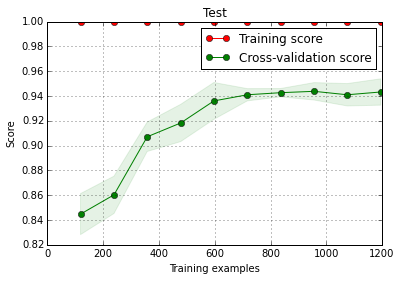

In [11]:
from sklearn.datasets import load_digits
from sklearn import svm
from sklearn.preprocessing import label_binarize


digits = load_digits()
X, y = digits.data, digits.target

parameters = {'kernel':('linear', 'rbf'), 'C':linspace(0.001, 1000,10)}
model = svm.SVC()
modelEvaluator(X, y, model, parameters)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 800 jobs       | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 986 out of 1000 | elapsed:   36.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   36.9s finished


Model best_params: {'C': 3.3636363636363638}
Model acc : 0.652173913043
Confusion matrix:
 [[16 14]
 [ 2 14]]
binary scores:
	 P  = 0.5
	 R  = 0.875
	 F1 = 0.636363636364
Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 800 jobs       | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 1250 jobs       | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 1800 jobs       | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2450 jobs       | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3200 jobs       | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3986 out of 4000 | elapsed:  2.5min remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  2.6min finished


Model best_params: {'kernel': 'linear', 'C': 21.181818181818183}
Model acc : 0.717391304348
Confusion matrix:
 [[19 11]
 [ 2 14]]
binary scores:
	 P  = 0.56
	 R  = 0.875
	 F1 = 0.682926829268


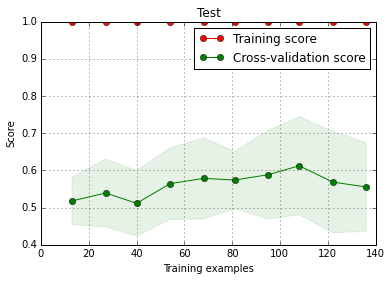

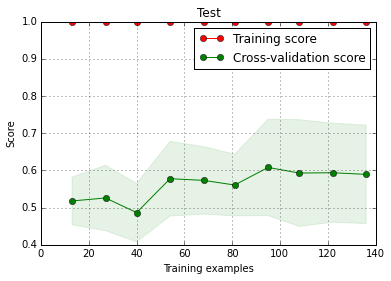

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import  GaussianNB
from sklearn.pipeline import  Pipeline 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
#svcPipe = Pipeline([('vectorize', vectorize), ('svc', SVC())])
#bayesPipe = Pipeline([('vectorize', vectorize), ('densen', DenseTransformer()), ('bayes', GaussianNB())])

parameters = { 'C':linspace(1, 10,100)}
X, y = d.get_samples('gender')


vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
Xvec = vectorize.fit_transform(X)
modelEvaluator(Xvec, y, LinearSVC(), parameters,num_flods=10)
#modelEvaluator(Xvec, y, LogisticRegression(), parameters,num_flods=10)


parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':linspace(1, 1000,100)}
modelEvaluator(Xvec, y, SVC(), parameters,num_flods=10)

#parameters = {}
#modelEvaluator(Xvec, y, RandomForestClassifier(), parameters,num_flods=10)
#modelEvaluator(Xvec, y, DecisionTreeClassifier(), parameters,num_flods=10)


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error


vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))

parameters = {}
X, y = d.get_samples('extroverted')
y = np.array(y, dtype=float)
vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
Xvec = vectorize.fit_transform(X)
model = modelEvaluator(Xvec, y, LinearRegression(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
modelEvaluator(Xvec, y, DecisionTreeRegressor(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
modelEvaluator(Xvec, y, RandomForestRegressor(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':linspace(0.01, 10,100)}
modelEvaluator(Xvec, y, SVR(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   1 out of  10 | elapsed:    0.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


Model best_params: {}
Model acc : -0.000199672749627
RMSE:  0.163854996947
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   1 out of  10 | elapsed:    0.5s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished


Model best_params: {}
Model acc : -0.158098591549
RMSE:  0.176314935617
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   1 out of  10 | elapsed:    2.6s remaining:   23.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


Model best_params: {}
Model acc : 0.0582957746479
RMSE:  0.158991386149
Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 800 jobs       | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 1250 jobs       | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 1800 jobs       | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 2450 jobs       | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 3200 jobs       | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3986 out of 4000 | elapsed:  1.3min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  1.3min finished


Model best_params: {'kernel': 'linear', 'C': 0.71636363636363631}
Model acc : 0.0488264699987
RMSE:  0.159788755433


SVR(C=0.71636363636363631, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.0, kernel='linear', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

In [28]:
vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))

parameters = {}
X, y = d.get_samples('stable')
y = np.array(y, dtype=float)
vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
Xvec = vectorize.fit_transform(X)
model = modelEvaluator(Xvec, y, LinearRegression(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
modelEvaluator(Xvec, y, DecisionTreeRegressor(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
modelEvaluator(Xvec, y, RandomForestRegressor(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':linspace(0.01, 10,100)}
modelEvaluator(Xvec, y, SVR(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   1 out of  10 | elapsed:    0.3s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


Model best_params: {}
Model score : 0.362852910872
RMSE:  0.185314612057
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished


Model best_params: {}
Model score : -0.689960543621
RMSE:  0.301806157197
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of  10 | elapsed:    2.8s remaining:   25.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


Model best_params: {}
Model score : -0.105895659798
RMSE:  0.244144468991
Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 800 jobs       | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 1250 jobs       | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 1800 jobs       | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 2450 jobs       | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3200 jobs       | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3986 out of 4000 | elapsed:  1.6min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  1.7min finished


Model best_params: {'kernel': 'linear', 'C': 0.81727272727272726}
Model score : 0.299059110165
RMSE:  0.194370571188


SVR(C=0.81727272727272726, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.0, kernel='linear', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

In [29]:
vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))

parameters = {}
X, y = d.get_samples('agreeable')
y = np.array(y, dtype=float)
vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
Xvec = vectorize.fit_transform(X)
model = modelEvaluator(Xvec, y, LinearRegression(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
modelEvaluator(Xvec, y, DecisionTreeRegressor(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
modelEvaluator(Xvec, y, RandomForestRegressor(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':linspace(0.01, 10,100)}
modelEvaluator(Xvec, y, SVR(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


Model best_params: {}
Model score : 0.0665931306101
RMSE:  0.170226549326
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   1 out of  10 | elapsed:    0.5s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished


Model best_params: {}
Model score : -0.624600395798
RMSE:  0.224576896872
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   1 out of  10 | elapsed:    2.5s remaining:   22.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.8s finished


Model best_params: {}
Model score : 0.00199117065002
RMSE:  0.176018773702
Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 800 jobs       | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1250 jobs       | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 1800 jobs       | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 2450 jobs       | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 3200 jobs       | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 3986 out of 4000 | elapsed:  1.2min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  1.2min finished


Model best_params: {'kernel': 'linear', 'C': 0.1109090909090909}
Model score : -0.0811495178509
RMSE:  0.183203884879


SVR(C=0.1109090909090909, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.0, kernel='linear', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

In [30]:
vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))

parameters = {}
X, y = d.get_samples('conscientious')
y = np.array(y, dtype=float)
vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
Xvec = vectorize.fit_transform(X)
model = modelEvaluator(Xvec, y, LinearRegression(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
modelEvaluator(Xvec, y, DecisionTreeRegressor(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
modelEvaluator(Xvec, y, RandomForestRegressor(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':linspace(0.01, 10,100)}
modelEvaluator(Xvec, y, SVR(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


Model best_params: {}
Model score : 0.0633345643033
RMSE:  0.156089477969
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


Model best_params: {}
Model score : -1.08938953488
RMSE:  0.23312620206
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finished


Model best_params: {}
Model score : -0.121584302326
RMSE:  0.170803726667
Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 800 jobs       | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1250 jobs       | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 1800 jobs       | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 2450 jobs       | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 3200 jobs       | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3986 out of 4000 | elapsed:  1.5min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  1.6min finished


Model best_params: {'kernel': 'linear', 'C': 0.31272727272727274}
Model score : 0.00767046150402
RMSE:  0.160660583705


SVR(C=0.31272727272727274, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.0, kernel='linear', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

In [32]:
vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))

parameters = {}
X, y = d.get_samples('open')
y = np.array(y, dtype=float)
vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
Xvec = vectorize.fit_transform(X)
model = modelEvaluator(Xvec, y, LinearRegression(normalize=True), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
modelEvaluator(Xvec, y, DecisionTreeRegressor(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
modelEvaluator(Xvec, y, RandomForestRegressor(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)
parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':linspace(0.01, 10,100)}
modelEvaluator(Xvec, y, SVR(), parameters,num_flods=10,scoring='mean_squared_error',classifier=False)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   1 out of  10 | elapsed:    0.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


Model best_params: {}
Model score : 0.31321032023
RMSE:  0.125866006313
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   1 out of  10 | elapsed:    0.5s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished


Model best_params: {}
Model score : -0.781192378611
RMSE:  0.202699177408
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of  10 | elapsed:    2.3s remaining:   21.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


Model best_params: {}
Model score : -0.0539192788363
RMSE:  0.15591943293
Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 800 jobs       | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 1250 jobs       | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 1800 jobs       | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 2450 jobs       | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 3200 jobs       | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3986 out of 4000 | elapsed:  1.5min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  1.5min finished


Model best_params: {'kernel': 'linear', 'C': 1.2209090909090909}
Model score : 0.189620686316
RMSE:  0.136722737493


SVR(C=1.2209090909090909, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.0, kernel='linear', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)